### RBF Hyperparameter exploration

This document seeks to explore hyperparameters of a RBF approach to interpolation of a hypersurface in an example case as well as provide ideally modifiable code to do such a hyperparameter exploration for any data set.





### Table of Contents

#### Linear RBFs 
a) <a href='#Rank Issues - low(ish) dimensionality representation'>Rank Issues - low(ish) dimensionality representation</a> 

b) <a href='#Loss - low(ish) dimensionality representation'>Loss - low(ish) dimensionality representation</a> 

c) <a href='#Rank Issues - large dimensionality representation'>Rank Issues - large dimensionality representation</a>

d) <a href='#Loss - large dimensionality representation'>Loss - large dimensionality representation</a> 

#### Multiquadratic RBFs


In [1]:
%matplotlib inline 

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import math
from mpl_toolkits.mplot3d import Axes3D

california_housing_dataframe_train = pd.read_csv("california_housing_train.csv", sep=",")
california_housing_dataframe_train = california_housing_dataframe_train.reindex( 
    np.random.permutation(california_housing_dataframe_train.index))

california_housing_dataframe_test = pd.read_csv("california_housing_test.csv", sep=",")
california_housing_dataframe_test = california_housing_dataframe_test.reindex( 
    np.random.permutation(california_housing_dataframe_test.index))

In [2]:
num_examples = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
test_examples = 100
L2Loss_all_0 = A=np.empty((len(num_examples),),dtype=object)
L2Loss_all_1 = A=np.empty((len(num_examples),),dtype=object)
L2Loss_all_01 = A=np.empty((len(num_examples),),dtype=object)


RankIssuesTot_0 = np.empty((len(num_examples),))
RankIssuesTot_1 = np.empty((len(num_examples),))
RankIssuesTot_01 = np.empty((len(num_examples),))


for num_example in num_examples:

    tempLoss_0 = []
    tempLoss_1 = []
    tempLoss_01 = []

    
    runs = 100
    tempRankIssues_0 = 0
    tempRankIssues_1 = 0
    tempRankIssues_01 = 0

    for run in range(runs):

        california_housing_dataframe_train = california_housing_dataframe_train.reindex( 
            np.random.permutation(california_housing_dataframe_train.index))

        data_train = np.zeros([num_example,3]) 
        data_train[:,0] = california_housing_dataframe_train.median_house_value[0:(num_example)].values # Median house value for household within a block ($1)
        data_train[:,1] = california_housing_dataframe_train.population[0:(num_example)].values # population in block
        data_train[:,2] = california_housing_dataframe_train.median_income[0:(num_example)].values # Median income for households within a block ($10k)


        california_housing_dataframe_test = california_housing_dataframe_test.reindex( 
            np.random.permutation(california_housing_dataframe_test.index))
        # I should be splitting the data into non-overlapping test and training examples, the only benefit of this is it allows some flexibility (if the training data set and the test data set together make up more than the total number of exampels I won't get an error here, I'll only get an error if either individually are too large)

        data_test = np.zeros([test_examples,3]) 
        data_test[:,0] = california_housing_dataframe_test.median_house_value[0:(test_examples)].values
        data_test[:,1] = california_housing_dataframe_test.population[0:(test_examples)].values
        data_test[:,2] = california_housing_dataframe_test.median_income[0:(test_examples)].values



        # Linear RBF interpolation (in 1D & 2D feature vectors)
        # Next hopefully I'll add loss and comparison to simple linear regression
        # Ultimately I want to have a switch-case here that allows users to choose their basis function. Ideally if they picked a paramterized basis they would be prompted to input paramters (or even better I guess the parameter space would be samples/explored)

        # Median House value -> income
        H_0 = np.zeros([num_example,num_example])
        # Block Population -> income
        H_1 = np.zeros([num_example,num_example])
        #Block Population*Population -> Income
        H_01 = np.zeros([num_example,num_example])


        for i in range(num_example): 
            for j in range(num_example):
                # Median House value -> income
                H_0[i,j] = (np.linalg.norm(data_train[j,0]-data_train[i,0]))
                # Block Population -> income
                H_1[i,j] = (np.linalg.norm(data_train[j,1]-data_train[i,1]))
                #Block Population*Population -> Income
                H_01[i,j] = (np.linalg.norm(data_train[j,[0,1]]-data_train[i,[0,1]]))

        
        # Median House value -> income
        if np.linalg.matrix_rank(H_0)==H_0.shape[1]:
            c_0 = np.matmul(np.linalg.inv(H_0),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_0 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_0[node]*np.linalg.norm(data_test[test_val,0]-data_train[node,0])
                y_hats_test_linear_0[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_0[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_0/datapoint = %s" %L2Loss_av)
            
            tempLoss_0 = np.append(tempLoss_0,L2Loss_av)
                            
        else: tempRankIssues_0 = tempRankIssues_0 + 1
            
            
        # Block Population -> income
        if np.linalg.matrix_rank(H_1)==H_1.shape[1]:
            c_1 = np.matmul(np.linalg.inv(H_1),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_1 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_1[node]*np.linalg.norm(data_test[test_val,1]-data_train[node,1])
                y_hats_test_linear_1[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_1[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_1/datapoint = %s" %L2Loss_av)
            
            tempLoss_1 = np.append(tempLoss_1,L2Loss_av)
                            
        else: tempRankIssues_1 = tempRankIssues_1 + 1
            
        #Block Population*Population -> Income
        if np.linalg.matrix_rank(H_01)==H_01.shape[1]:
            c_01 = np.matmul(np.linalg.inv(H_01),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_01 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_01[node]*np.linalg.norm(data_test[test_val,[0,1]]-data_train[node,[0,1]])
                y_hats_test_linear_01[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_01[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_01/datapoint = %s" %L2Loss_av)
            
            tempLoss_01 = np.append(tempLoss_01,L2Loss_av)
                            
        else: tempRankIssues_01 = tempRankIssues_01 + 1
            
    Indexx = int((num_example/10)-1)
    L2Loss_all_0[Indexx] = tempLoss_0
    L2Loss_all_1[Indexx] = tempLoss_1
    L2Loss_all_01[Indexx] = tempLoss_01

    RankIssuesTot_0[Indexx] = tempRankIssues_0/runs
    RankIssuesTot_1[Indexx] = tempRankIssues_1/runs
    RankIssuesTot_01[Indexx] = tempRankIssues_01/runs


L2Loss_0/datapoint = 7.114806906305455
L2Loss_1/datapoint = 19.243520999597532
L2Loss_01/datapoint = 7.143303965888461
L2Loss_1/datapoint = 10.158291865221377
L2Loss_01/datapoint = 2.469743032921629
L2Loss_0/datapoint = 5.612886425710009
L2Loss_1/datapoint = 14.860459651916848
L2Loss_01/datapoint = 5.595597671708192
L2Loss_0/datapoint = 2.9507278777073807
L2Loss_1/datapoint = 6.112719632593613
L2Loss_01/datapoint = 2.9396381703990566
L2Loss_0/datapoint = 2.384738793786761
L2Loss_1/datapoint = 3.910099039991077
L2Loss_01/datapoint = 2.3838551655175264
L2Loss_0/datapoint = 2.1558697566266627
L2Loss_1/datapoint = 3.7913695995416727
L2Loss_01/datapoint = 2.0444922653394064
L2Loss_0/datapoint = 2.404556178998254
L2Loss_1/datapoint = 11.270334685071441
L2Loss_01/datapoint = 2.346858925575342
L2Loss_0/datapoint = 4.736055135260487
L2Loss_1/datapoint = 11.638878142688348
L2Loss_01/datapoint = 4.7223655240136715
L2Loss_0/datapoint = 5.177811176967639
L2Loss_1/datapoint = 3.4676834568126464
L2Lo

L2Loss_01/datapoint = 2.932547068006321
L2Loss_0/datapoint = 3.856347452852155
L2Loss_1/datapoint = 37.68089405610899
L2Loss_01/datapoint = 3.8475952350514278
L2Loss_0/datapoint = 2.737118845181074
L2Loss_1/datapoint = 5.260934326838108
L2Loss_01/datapoint = 2.692933027173982
L2Loss_1/datapoint = 5.054752087276023
L2Loss_01/datapoint = 1.9753078686717513
L2Loss_0/datapoint = 2.501760664662937
L2Loss_1/datapoint = 4.991539287330851
L2Loss_01/datapoint = 2.425564591915504
L2Loss_0/datapoint = 2.5945024640145573
L2Loss_1/datapoint = 4.964855312225264
L2Loss_01/datapoint = 2.4585413415961357
L2Loss_0/datapoint = 3.9187848526031734
L2Loss_1/datapoint = 44.32265962144492
L2Loss_01/datapoint = 3.7569855027941044
L2Loss_0/datapoint = 3.908680229687892
L2Loss_1/datapoint = 22.776469618333056
L2Loss_01/datapoint = 3.8974543601348866
L2Loss_0/datapoint = 2.659373557372636
L2Loss_1/datapoint = 4.974000271968396
L2Loss_01/datapoint = 2.6762363877242303
L2Loss_0/datapoint = 7.054813238202062
L2Loss_

L2Loss_0/datapoint = 3.435597936265298
L2Loss_1/datapoint = 6.96735507457666
L2Loss_01/datapoint = 3.4296288915138193
L2Loss_0/datapoint = 2.7374065735229176
L2Loss_1/datapoint = 4.075507608069042
L2Loss_01/datapoint = 2.5964051322344535
L2Loss_0/datapoint = 2.902003448388509
L2Loss_1/datapoint = 4.9955633545423845
L2Loss_01/datapoint = 2.743657515859101
L2Loss_0/datapoint = 2.133183426155452
L2Loss_1/datapoint = 9.35003489178854
L2Loss_01/datapoint = 2.065660302964549
L2Loss_1/datapoint = 4.172880876184135
L2Loss_01/datapoint = 3.611397030204943
L2Loss_0/datapoint = 3.627601491265395
L2Loss_1/datapoint = 4.786870616650454
L2Loss_01/datapoint = 3.5866601602906503
L2Loss_1/datapoint = 7.504063698662184
L2Loss_01/datapoint = 4.252050208688665
L2Loss_0/datapoint = 2.1420560996905462
L2Loss_1/datapoint = 4.7625196218334285
L2Loss_01/datapoint = 2.1097495781763174
L2Loss_1/datapoint = 15.545665630932962
L2Loss_01/datapoint = 3.462498995015557
L2Loss_0/datapoint = 2.8588423712657063
L2Loss_1

L2Loss_1/datapoint = 4.4030922699362405
L2Loss_01/datapoint = 3.501734064387549
L2Loss_0/datapoint = 2.588051533072545
L2Loss_1/datapoint = 4.901955896614997
L2Loss_01/datapoint = 2.516712259528445
L2Loss_1/datapoint = 13.793480821779362
L2Loss_01/datapoint = 3.120487272634931
L2Loss_01/datapoint = 3.4350384515048997
L2Loss_01/datapoint = 2.015940891861249
L2Loss_0/datapoint = 4.045268805431885
L2Loss_1/datapoint = 5.1241789455395805
L2Loss_01/datapoint = 3.9984746676779177
L2Loss_0/datapoint = 5.155896732368518
L2Loss_1/datapoint = 6.347539328072595
L2Loss_01/datapoint = 5.090209274494436
L2Loss_1/datapoint = 3.0695051260998536
L2Loss_01/datapoint = 2.0120763485051003
L2Loss_1/datapoint = 7.208463874342583
L2Loss_01/datapoint = 3.0846118917693803
L2Loss_01/datapoint = 2.4604730477623544
L2Loss_01/datapoint = 2.7387030594915776
L2Loss_1/datapoint = 5.171484081272199
L2Loss_01/datapoint = 1.7933566861323706
L2Loss_0/datapoint = 2.5674471296992647
L2Loss_1/datapoint = 4.861696214147193
L

L2Loss_1/datapoint = 4.925529402112906
L2Loss_01/datapoint = 2.8870463973375116
L2Loss_1/datapoint = 7.222367447508763
L2Loss_01/datapoint = 2.76979897646812
L2Loss_0/datapoint = 2.5733758246456797
L2Loss_1/datapoint = 3.851668102033084
L2Loss_01/datapoint = 2.582316080640422
L2Loss_1/datapoint = 7.860579449106212
L2Loss_01/datapoint = 3.156917241317002
L2Loss_0/datapoint = 2.787503335623788
L2Loss_1/datapoint = 5.914778981592531
L2Loss_01/datapoint = 2.7721117178561285
L2Loss_1/datapoint = 5.182425535551942
L2Loss_01/datapoint = 3.2837127590184254
L2Loss_1/datapoint = 6.526994885015162
L2Loss_01/datapoint = 2.7606718438918194
L2Loss_1/datapoint = 6.835135240221653
L2Loss_01/datapoint = 1.997017226657758
L2Loss_1/datapoint = 4.035545313441242
L2Loss_01/datapoint = 1.8029615629702371
L2Loss_0/datapoint = 2.999709170692591
L2Loss_1/datapoint = 7.04169475582399
L2Loss_01/datapoint = 2.88386117199848
L2Loss_1/datapoint = 4.092124256717699
L2Loss_01/datapoint = 2.1342402163687466
L2Loss_01/

L2Loss_01/datapoint = 3.6742962130395695
L2Loss_1/datapoint = 5.620137768883467
L2Loss_01/datapoint = 2.9412353452854996
L2Loss_1/datapoint = 6.148549977708257
L2Loss_01/datapoint = 2.445082802442543
L2Loss_0/datapoint = 3.021579235188049
L2Loss_1/datapoint = 5.507516462720714
L2Loss_01/datapoint = 2.901885523196499
L2Loss_1/datapoint = 5.937433390209903
L2Loss_01/datapoint = 4.6236946274739115
L2Loss_0/datapoint = 3.767579727854889
L2Loss_1/datapoint = 4.989184221227336
L2Loss_01/datapoint = 3.6905316107793324
L2Loss_1/datapoint = 5.918655741536769
L2Loss_01/datapoint = 3.104634385123437
L2Loss_1/datapoint = 6.145844137997244
L2Loss_01/datapoint = 3.5675530947934004
L2Loss_1/datapoint = 8.067057843004683
L2Loss_01/datapoint = 4.234755836903059
L2Loss_1/datapoint = 11.973321616269578
L2Loss_01/datapoint = 1.754392273193056
L2Loss_01/datapoint = 3.048210517115622
L2Loss_0/datapoint = 3.6746486512264185
L2Loss_1/datapoint = 5.978637024968233
L2Loss_01/datapoint = 3.605898795749045
L2Loss

L2Loss_1/datapoint = 6.771158370827103
L2Loss_01/datapoint = 3.4613984298886193
L2Loss_01/datapoint = 2.9150279869196067
L2Loss_1/datapoint = 9.879702994606292
L2Loss_01/datapoint = 5.191839970920813
L2Loss_1/datapoint = 8.732797378168556
L2Loss_01/datapoint = 4.240357491876802
L2Loss_1/datapoint = 4.505340924441399
L2Loss_01/datapoint = 2.9276357505127755
L2Loss_1/datapoint = 4.204012881978677
L2Loss_01/datapoint = 3.1621675963585854
L2Loss_01/datapoint = 2.193727496302319
L2Loss_01/datapoint = 2.9754595903150034
L2Loss_1/datapoint = 5.429114069843525
L2Loss_01/datapoint = 2.886287529210094
L2Loss_1/datapoint = 6.8908125738443315
L2Loss_01/datapoint = 4.823717722912945
L2Loss_1/datapoint = 7.460890118626264
L2Loss_01/datapoint = 2.7202348467607815
L2Loss_01/datapoint = 2.6595886891258123
L2Loss_01/datapoint = 3.818210520007507
L2Loss_0/datapoint = 2.7524409276456954
L2Loss_01/datapoint = 2.6603207727039724
L2Loss_1/datapoint = 4.61097562610351
L2Loss_01/datapoint = 2.4763377017495505


L2Loss_01/datapoint = 3.105126810426408
L2Loss_01/datapoint = 2.835937518391475
L2Loss_01/datapoint = 3.4261920102229135
L2Loss_01/datapoint = 2.537744734457152
L2Loss_01/datapoint = 2.2291780710808227
L2Loss_01/datapoint = 5.501575620351937
L2Loss_01/datapoint = 2.4331561852295223
L2Loss_01/datapoint = 2.775172080022717
L2Loss_01/datapoint = 3.975842264927958
L2Loss_1/datapoint = 6.1625056156526465
L2Loss_01/datapoint = 3.6145444439823193
L2Loss_1/datapoint = 5.473819356436487
L2Loss_01/datapoint = 2.926917379582219
L2Loss_01/datapoint = 5.516841873128827
L2Loss_01/datapoint = 3.190997564122242
L2Loss_01/datapoint = 2.669145608669878
L2Loss_01/datapoint = 3.7497399874770396
L2Loss_01/datapoint = 1.6343689092185314
L2Loss_01/datapoint = 2.4297814084335663
L2Loss_1/datapoint = 6.335762573278191
L2Loss_01/datapoint = 2.834239153215342
L2Loss_01/datapoint = 4.1320266156828716
L2Loss_01/datapoint = 3.9087771047013367
L2Loss_1/datapoint = 5.115930575125686
L2Loss_01/datapoint = 3.1241449558

L2Loss_01/datapoint = 2.953428281379898
L2Loss_1/datapoint = 6.960704329226229
L2Loss_01/datapoint = 2.7351980133042133
L2Loss_1/datapoint = 5.567322604724374
L2Loss_01/datapoint = 1.8504329156136083
L2Loss_01/datapoint = 1.915365015116685
L2Loss_1/datapoint = 7.046223859221819
L2Loss_01/datapoint = 1.9329125379724297
L2Loss_01/datapoint = 2.3512177098069444
L2Loss_01/datapoint = 3.2650654744510046
L2Loss_01/datapoint = 2.4013202266030382
L2Loss_01/datapoint = 2.6338307030115984
L2Loss_01/datapoint = 4.4560645544838655
L2Loss_1/datapoint = 4.9628137937619154
L2Loss_01/datapoint = 2.6887266309285622
L2Loss_01/datapoint = 3.8351353165806996
L2Loss_01/datapoint = 3.0700342792532003
L2Loss_01/datapoint = 2.548028819445566
L2Loss_01/datapoint = 2.4964108857543166
L2Loss_0/datapoint = 1.9245040788046053
L2Loss_01/datapoint = 1.9487938082129725
L2Loss_01/datapoint = 2.5868181640113237
L2Loss_01/datapoint = 2.288315542541495
L2Loss_1/datapoint = 7.091584782192306
L2Loss_01/datapoint = 2.294953

L2Loss_01/datapoint = 3.9999180480725416
L2Loss_01/datapoint = 3.344026976984988
L2Loss_1/datapoint = 5.893838496106224
L2Loss_01/datapoint = 3.0828197875981815
L2Loss_1/datapoint = 3.972692742411094
L2Loss_01/datapoint = 2.578477975046563
L2Loss_01/datapoint = 6.072261811049085
L2Loss_01/datapoint = 3.574592616645894
L2Loss_01/datapoint = 2.746250429138465
L2Loss_1/datapoint = 3.492467933676573
L2Loss_01/datapoint = 2.7731562287529323
L2Loss_01/datapoint = 3.3048936086261747
L2Loss_01/datapoint = 2.1437976575366546
L2Loss_01/datapoint = 2.82003972456307
L2Loss_01/datapoint = 3.418367030801891
L2Loss_01/datapoint = 2.667538344400804
L2Loss_01/datapoint = 2.9712176541539224
L2Loss_01/datapoint = 2.631572544549756
L2Loss_01/datapoint = 1.6854379942927133
L2Loss_01/datapoint = 2.9543632024936812
L2Loss_01/datapoint = 3.349986479043455
L2Loss_01/datapoint = 3.0290546678246164
L2Loss_01/datapoint = 2.5409911336451607
L2Loss_01/datapoint = 2.386156702978159
L2Loss_01/datapoint = 3.6770778878

#### Rank Issues - low(ish) dimensionality representaiton
<a id='Rank Issues - low(ish) dimensionality representation'></a>

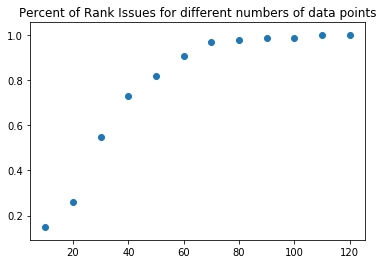

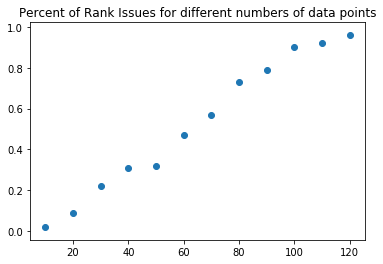

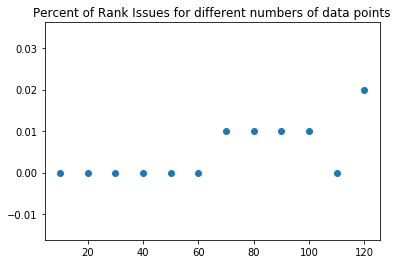

In [3]:
plt.scatter(num_examples, RankIssuesTot_0);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

plt.scatter(num_examples, RankIssuesTot_1);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

plt.scatter(num_examples, RankIssuesTot_01);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

In [4]:
AllIssueofRank_0 = (np.where(RankIssuesTot_0 == 1))

L2Loss_all_modified_0 = L2Loss_all_0
num_examples_modified_0 = num_examples

flag = 0
while flag < len(AllIssueofRank_0[0]):
    L2Loss_all_modified_0 = np.delete(L2Loss_all_modified_0,AllIssueofRank_0[0][len(AllIssueofRank_0[0])-(1+flag)])
    num_examples_modified_0 = np.delete(num_examples_modified_0,AllIssueofRank_0[0][len(AllIssueofRank_0[0])-(1+flag)])
    
    flag = flag + 1
    
AllIssueofRank_1 = (np.where(RankIssuesTot_1 == 1))

L2Loss_all_modified_1 = L2Loss_all_1
num_examples_modified_1 = num_examples

flag = 0
while flag < len(AllIssueofRank_1[0]):
    L2Loss_all_modified_1 = np.delete(L2Loss_all_modified_1,AllIssueofRank_1[0][len(AllIssueofRank_1[0])-(1+flag)])
    num_examples_modified_1 = np.delete(num_examples_modified_1,AllIssueofRank_1[0][len(AllIssueofRank_1[0])-(1+flag)])
    
    flag = flag + 1
    
AllIssueofRank_01 = (np.where(RankIssuesTot_01 == 1))

L2Loss_all_modified_01 = L2Loss_all_01
num_examples_modified_01 = num_examples

flag = 0
while flag < len(AllIssueofRank_01[0]):
    L2Loss_all_modified_01 = np.delete(L2Loss_all_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    num_examples_modified_01 = np.delete(num_examples_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    
    flag = flag + 1

Loss - low(ish) dimensionality representation
<a id='#Loss - low(ish) dimensionality representation'></a>


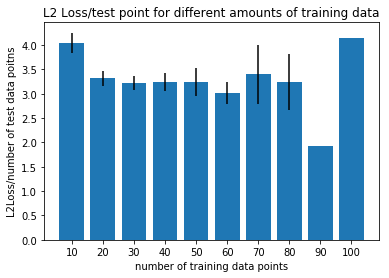

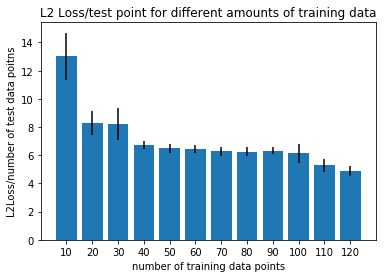

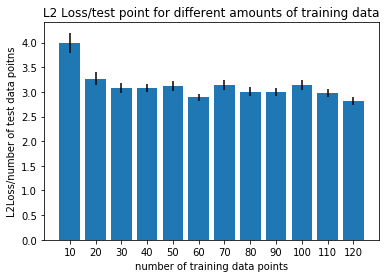

In [5]:
num4It = (len(L2Loss_all_modified_0))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_0[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_0[stttats])/math.sqrt(len(L2Loss_all_modified_0[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_0[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,num_examples_modified_0)
plt.xlabel('number of training data points')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()

num4It = (len(L2Loss_all_modified_1))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_1[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_1[stttats])/math.sqrt(len(L2Loss_all_modified_1[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_1[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,num_examples_modified_1)
plt.xlabel('number of training data points')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()

num4It = (len(L2Loss_all_modified_01))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_01[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_01[stttats])/math.sqrt(len(L2Loss_all_modified_01[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_01[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,num_examples_modified_01)
plt.xlabel('number of training data points')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()

In [6]:
num_examples = [100, 200, 300, 400, 500, 600]
test_examples = 100
L2Loss_all_01 = A=np.empty((len(num_examples),),dtype=object)
RankIssuesTot_01 = np.empty((len(num_examples),))


for num_example in num_examples:

    tempLoss_01 = []

    runs = 20
    tempRankIssues_01 = 0

    for run in range(runs):

        california_housing_dataframe_train = california_housing_dataframe_train.reindex( 
            np.random.permutation(california_housing_dataframe_train.index))

        data_train = np.zeros([num_example,3]) 
        data_train[:,0] = california_housing_dataframe_train.median_house_value[0:(num_example)].values # Median house value for household within a block ($1)
        data_train[:,1] = california_housing_dataframe_train.population[0:(num_example)].values # population in block
        data_train[:,2] = california_housing_dataframe_train.median_income[0:(num_example)].values # Median income for households within a block ($10k)


        california_housing_dataframe_test = california_housing_dataframe_test.reindex( 
            np.random.permutation(california_housing_dataframe_test.index))
        # I should be splitting the data into non-overlapping test and training examples, the only benefit of this is it allows some flexibility (if the training data set and the test data set together make up more than the total number of exampels I won't get an error here, I'll only get an error if either individually are too large)

        data_test = np.zeros([test_examples,3]) 
        data_test[:,0] = california_housing_dataframe_test.median_house_value[0:(test_examples)].values
        data_test[:,1] = california_housing_dataframe_test.population[0:(test_examples)].values
        data_test[:,2] = california_housing_dataframe_test.median_income[0:(test_examples)].values

        H_01 = np.zeros([num_example,num_example])

        for i in range(num_example): 
            for j in range(num_example):
                #Block Population*Population -> Income
                H_01[i,j] = (np.linalg.norm(data_train[j,[0,1]]-data_train[i,[0,1]]))
                
        #Block Population*Population -> Income
        if np.linalg.matrix_rank(H_01)==H_01.shape[1]:
            c_01 = np.matmul(np.linalg.inv(H_01),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_01 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_01[node]*np.linalg.norm(data_test[test_val,[0,1]]-data_train[node,[0,1]])
                y_hats_test_linear_01[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_01[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_01/datapoint = %s" %L2Loss_av)
            
            tempLoss_01 = np.append(tempLoss_01,L2Loss_av)
                            
        else: tempRankIssues_01 = tempRankIssues_01 + 1
            
    Indexx = int((num_example/100)-1)
    L2Loss_all_01[Indexx] = tempLoss_01
    RankIssuesTot_01[Indexx] = tempRankIssues_01/runs

L2Loss_01/datapoint = 2.1204123364779046
L2Loss_01/datapoint = 2.943114840395867
L2Loss_01/datapoint = 2.284951826770434
L2Loss_01/datapoint = 1.8634927688547527
L2Loss_01/datapoint = 2.7212334870378796
L2Loss_01/datapoint = 2.481277657600351
L2Loss_01/datapoint = 2.424807173233632
L2Loss_01/datapoint = 2.8532094192953794
L2Loss_01/datapoint = 2.6381891062819687
L2Loss_01/datapoint = 4.507856002906368
L2Loss_01/datapoint = 2.09834409231985
L2Loss_01/datapoint = 2.965244215288026
L2Loss_01/datapoint = 2.2066305959747554
L2Loss_01/datapoint = 4.261918855555598
L2Loss_01/datapoint = 2.013160272287655
L2Loss_01/datapoint = 2.172574000696506
L2Loss_01/datapoint = 3.332303231474287
L2Loss_01/datapoint = 2.783905091851254
L2Loss_01/datapoint = 2.3064041381537104
L2Loss_01/datapoint = 3.3312582106248714
L2Loss_01/datapoint = 3.1400328619254303
L2Loss_01/datapoint = 2.2005860964283284
L2Loss_01/datapoint = 3.2954110987429335
L2Loss_01/datapoint = 2.56209003677084
L2Loss_01/datapoint = 2.8653988

Rank Issues - large dimensionality representation

<a id='#Rank Issues - large dimensionality representation'></a>


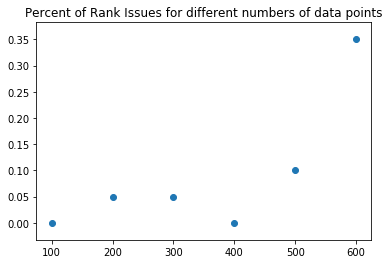

In [7]:
plt.scatter(num_examples, RankIssuesTot_01);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

In [8]:
AllIssueofRank_01 = (np.where(RankIssuesTot_01 == 1))
AllIssueofRank_01

(array([], dtype=int64),)

In [9]:
AllIssueofRank_01 = (np.where(RankIssuesTot_01 == 1))

L2Loss_all_modified_01 = L2Loss_all_01
num_examples_modified_01 = num_examples

flag = 0
while flag < len(AllIssueofRank_01[0]):
    L2Loss_all_modified_01 = np.delete(L2Loss_all_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    num_examples_modified_01 = np.delete(num_examples_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    
    flag = flag + 1

Loss - large dimensionality representation
<a id='#Loss - large dimensionality representation'></a>


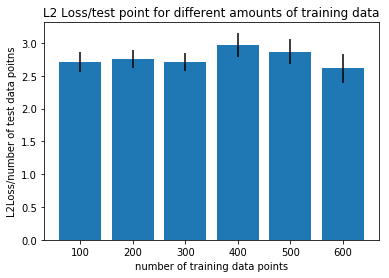

In [10]:
num4It = (len(L2Loss_all_modified_01))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_01[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_01[stttats])/math.sqrt(len(L2Loss_all_modified_01[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_01[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,num_examples_modified_01)
plt.xlabel('number of training data points')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()

In [11]:
num_example = 40
const = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4]
test_examples = 100
L2Loss_all_0 = A=np.empty((len(const),),dtype=object)
L2Loss_all_1 = A=np.empty((len(const),),dtype=object)
L2Loss_all_01 = A=np.empty((len(const),),dtype=object)


RankIssuesTot_0 = np.empty((len(const),))
RankIssuesTot_1 = np.empty((len(const),))
RankIssuesTot_01 = np.empty((len(const),))


for cons in const:

    tempLoss_0 = []
    tempLoss_1 = []
    tempLoss_01 = []

    
    runs = 50
    tempRankIssues_0 = 0
    tempRankIssues_1 = 0
    tempRankIssues_01 = 0

    for run in range(runs):

        california_housing_dataframe_train = california_housing_dataframe_train.reindex( 
            np.random.permutation(california_housing_dataframe_train.index))

        data_train = np.zeros([num_example,3]) 
        data_train[:,0] = california_housing_dataframe_train.median_house_value[0:(num_example)].values # Median house value for household within a block ($1)
        data_train[:,1] = california_housing_dataframe_train.population[0:(num_example)].values # population in block
        data_train[:,2] = california_housing_dataframe_train.median_income[0:(num_example)].values # Median income for households within a block ($10k)


        california_housing_dataframe_test = california_housing_dataframe_test.reindex( 
            np.random.permutation(california_housing_dataframe_test.index))
        # I should be splitting the data into non-overlapping test and training examples, the only benefit of this is it allows some flexibility (if the training data set and the test data set together make up more than the total number of exampels I won't get an error here, I'll only get an error if either individually are too large)

        data_test = np.zeros([test_examples,3]) 
        data_test[:,0] = california_housing_dataframe_test.median_house_value[0:(test_examples)].values
        data_test[:,1] = california_housing_dataframe_test.population[0:(test_examples)].values
        data_test[:,2] = california_housing_dataframe_test.median_income[0:(test_examples)].values



        # Linear RBF interpolation (in 1D & 2D feature vectors)
        # Next hopefully I'll add loss and comparison to simple linear regression
        # Ultimately I want to have a switch-case here that allows users to choose their basis function. Ideally if they picked a paramterized basis they would be prompted to input paramters (or even better I guess the parameter space would be samples/explored)

        # Median House value -> income
        H_0 = np.zeros([num_example,num_example])
        # Block Population -> income
        H_1 = np.zeros([num_example,num_example])
        #Block Population*Population -> Income
        H_01 = np.zeros([num_example,num_example])


        for i in range(num_example): 
            for j in range(num_example):
                # Median House value -> income
                H_0[i,j] = math.exp(-(((np.linalg.norm(data_train[j,0]-data_train[i,0]))/cons)**2))
                # Block Population -> income
                H_1[i,j] = math.exp(-(((np.linalg.norm(data_train[j,1]-data_train[i,1]))/cons)**2))
                #Block Population*Population -> Income
                H_01[i,j] = math.exp(-(((np.linalg.norm(data_train[j,[0,1]]-data_train[i,[0,1]]))/cons)**2))

        
        # Median House value -> income
        if np.linalg.matrix_rank(H_0)==H_0.shape[1]:
            c_0 = np.matmul(np.linalg.inv(H_0),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_0 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_0[node]*math.exp(-(((np.linalg.norm(data_test[test_val,0]-data_train[node,0]))/cons)**2))
                y_hats_test_linear_0[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_0[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_0/datapoint = %s" %L2Loss_av)
            
            tempLoss_0 = np.append(tempLoss_0,L2Loss_av)
                            
        else: tempRankIssues_0 = tempRankIssues_0 + 1
            
            
        # Block Population -> income
        if np.linalg.matrix_rank(H_1)==H_1.shape[1]:
            c_1 = np.matmul(np.linalg.inv(H_1),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_1 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_1[node]*math.exp(-(((np.linalg.norm(data_test[test_val,1]-data_train[node,1]))/cons)**2))
                y_hats_test_linear_1[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_1[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_1/datapoint = %s" %L2Loss_av)
            
            tempLoss_1 = np.append(tempLoss_1,L2Loss_av)
                            
        else: tempRankIssues_1 = tempRankIssues_1 + 1
            
        #Block Population*Population -> Income
        if np.linalg.matrix_rank(H_01)==H_01.shape[1]:
            c_01 = np.matmul(np.linalg.inv(H_01),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_01 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_01[node]*math.exp(-(((np.linalg.norm(data_test[test_val,[0,1]]-data_train[node,[0,1]]))/cons)**2))
                y_hats_test_linear_01[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_01[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_01/datapoint = %s" %L2Loss_av)
            
            tempLoss_01 = np.append(tempLoss_01,L2Loss_av)
                            
        else: tempRankIssues_01 = tempRankIssues_01 + 1
            
    Indexx = int((cons*5)-1)
    L2Loss_all_0[Indexx] = tempLoss_0
    L2Loss_all_1[Indexx] = tempLoss_1
    L2Loss_all_01[Indexx] = tempLoss_01

    RankIssuesTot_0[Indexx] = tempRankIssues_0/runs
    RankIssuesTot_1[Indexx] = tempRankIssues_1/runs
    RankIssuesTot_01[Indexx] = tempRankIssues_01/runs


L2Loss_0/datapoint = 15.449689810899999
L2Loss_1/datapoint = 15.869218366895332
L2Loss_01/datapoint = 15.869218366899997
L2Loss_1/datapoint = 16.227473920583588
L2Loss_01/datapoint = 16.260970202999996
L2Loss_1/datapoint = 19.81893989398269
L2Loss_01/datapoint = 20.395377294900005
L2Loss_0/datapoint = 16.370366349699992
L2Loss_01/datapoint = 17.822337905999994
L2Loss_1/datapoint = 18.33027658798993
L2Loss_01/datapoint = 18.533727447800004
L2Loss_1/datapoint = 20.03247907808216
L2Loss_01/datapoint = 20.424569991700004
L2Loss_01/datapoint = 18.058732224299998
L2Loss_1/datapoint = 17.28201884138005
L2Loss_01/datapoint = 17.104896956599994
L2Loss_0/datapoint = 17.040135736700005
L2Loss_1/datapoint = 16.952145127991788
L2Loss_01/datapoint = 17.150625901200005
L2Loss_1/datapoint = 17.057410401491488
L2Loss_01/datapoint = 16.8649650854
L2Loss_1/datapoint = 13.764300080077751
L2Loss_01/datapoint = 15.375323813700003
L2Loss_1/datapoint = 17.340900706189835
L2Loss_01/datapoint = 17.5587321573999

L2Loss_01/datapoint = 15.2181156553
L2Loss_1/datapoint = 15.404117693979597
L2Loss_01/datapoint = 15.461866087099999
L2Loss_01/datapoint = 19.202904633899994
L2Loss_1/datapoint = 17.352883844645998
L2Loss_01/datapoint = 17.505594308799992
L2Loss_01/datapoint = 16.629729459399996
L2Loss_1/datapoint = 16.37076527038863
L2Loss_01/datapoint = 16.0987414412
L2Loss_01/datapoint = 16.233841860200002
L2Loss_1/datapoint = 19.493492760053815
L2Loss_01/datapoint = 20.054137527199995
L2Loss_01/datapoint = 17.7987255965
L2Loss_0/datapoint = 15.605649882100003
L2Loss_1/datapoint = 15.666987165170791
L2Loss_01/datapoint = 16.3073757409
L2Loss_01/datapoint = 14.7010132471
L2Loss_1/datapoint = 14.727408120392253
L2Loss_01/datapoint = 14.901684901399994
L2Loss_1/datapoint = 18.794556288384246
L2Loss_01/datapoint = 18.85260802369999
L2Loss_0/datapoint = 13.089598063427443
L2Loss_1/datapoint = 16.568554344391295
L2Loss_01/datapoint = 16.916657417200007
L2Loss_01/datapoint = 18.8640655312
L2Loss_1/datapoin

L2Loss_1/datapoint = 21.902665456782824
L2Loss_01/datapoint = 22.399094484299997
L2Loss_0/datapoint = 14.568321105838239
L2Loss_01/datapoint = 18.4040091556
L2Loss_01/datapoint = 18.896583178186592
L2Loss_01/datapoint = 17.861089653399993
L2Loss_01/datapoint = 17.867239173600005
L2Loss_0/datapoint = 15.828630815299999
L2Loss_01/datapoint = 18.508913685699998
L2Loss_0/datapoint = 22.0639993285
L2Loss_01/datapoint = 22.369543051999997
L2Loss_0/datapoint = 18.806949874900003
L2Loss_1/datapoint = 17.938568225506007
L2Loss_01/datapoint = 18.806949874900003
L2Loss_0/datapoint = 15.565482850599999
L2Loss_1/datapoint = 15.976321857683734
L2Loss_01/datapoint = 16.200314425299997
L2Loss_0/datapoint = 15.963051131899999
L2Loss_1/datapoint = 15.942667701713981
L2Loss_01/datapoint = 16.2703020069
L2Loss_1/datapoint = 17.66658403957153
L2Loss_01/datapoint = 17.887718137099995
L2Loss_0/datapoint = 17.855840091799998
L2Loss_1/datapoint = 21.10254808277916
L2Loss_01/datapoint = 21.353522826499994
L2Los

L2Loss_01/datapoint = 16.326355705299996
L2Loss_1/datapoint = 18.561296861459493
L2Loss_01/datapoint = 20.34414489753515
L2Loss_0/datapoint = 16.353265700177825
L2Loss_1/datapoint = 20.427815755354658
L2Loss_01/datapoint = 20.83924103919999
L2Loss_01/datapoint = 19.894594063400003
L2Loss_1/datapoint = 21.14063420087216
L2Loss_01/datapoint = 21.516968317000007
L2Loss_01/datapoint = 16.444723862
L2Loss_1/datapoint = 17.395360215219114
L2Loss_01/datapoint = 17.818335840900005
L2Loss_01/datapoint = 13.219824163599998
L2Loss_1/datapoint = 18.065539786982473
L2Loss_01/datapoint = 18.6732549855
L2Loss_01/datapoint = 18.922637838399993
L2Loss_1/datapoint = 21.321840331739963
L2Loss_01/datapoint = 21.840503235699995
L2Loss_1/datapoint = 18.98797291302779
L2Loss_01/datapoint = 20.081530402999995
L2Loss_0/datapoint = 15.10225665699999
L2Loss_01/datapoint = 17.88018923922639
L2Loss_1/datapoint = 17.68470855827768
L2Loss_01/datapoint = 18.70990253440001
L2Loss_0/datapoint = 14.578196950900006
L2Los

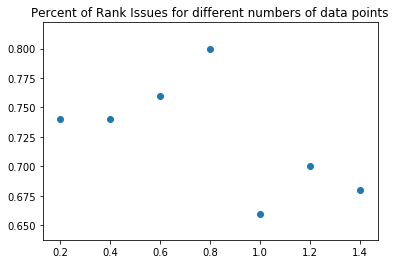

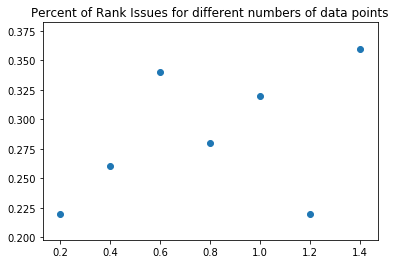

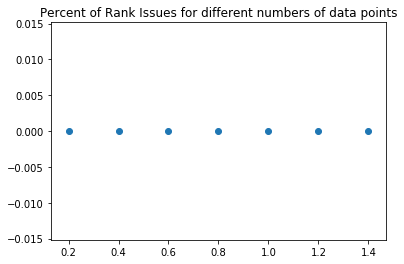

In [12]:
plt.scatter(const, RankIssuesTot_0);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

plt.scatter(const, RankIssuesTot_1);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

plt.scatter(const, RankIssuesTot_01);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

In [13]:
AllIssueofRank_0 = (np.where(RankIssuesTot_0 == 1))

L2Loss_all_modified_0 = L2Loss_all_0
const_modified_0 = const

flag = 0
while flag < len(AllIssueofRank_0[0]):
    L2Loss_all_modified_0 = np.delete(L2Loss_all_modified_0,AllIssueofRank_0[0][len(AllIssueofRank_0[0])-(1+flag)])
    const_modified_0 = np.delete(const_modified_0,AllIssueofRank_0[0][len(AllIssueofRank_0[0])-(1+flag)])
    
    flag = flag + 1
    
AllIssueofRank_1 = (np.where(RankIssuesTot_1 == 1))

L2Loss_all_modified_1 = L2Loss_all_1
const_modified_1 = const

flag = 0
while flag < len(AllIssueofRank_1[0]):
    L2Loss_all_modified_1 = np.delete(L2Loss_all_modified_1,AllIssueofRank_1[0][len(AllIssueofRank_1[0])-(1+flag)])
    const_modified_1 = np.delete(const_modified_1,AllIssueofRank_1[0][len(AllIssueofRank_1[0])-(1+flag)])
    
    flag = flag + 1
    
AllIssueofRank_01 = (np.where(RankIssuesTot_01 == 1))

L2Loss_all_modified_01 = L2Loss_all_01
const_modified_01 = const

flag = 0
while flag < len(AllIssueofRank_01[0]):
    L2Loss_all_modified_01 = np.delete(L2Loss_all_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    const_modified_01 = np.delete(const_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    
    flag = flag + 1

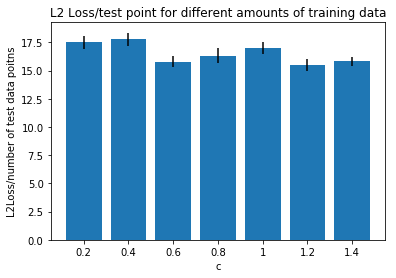

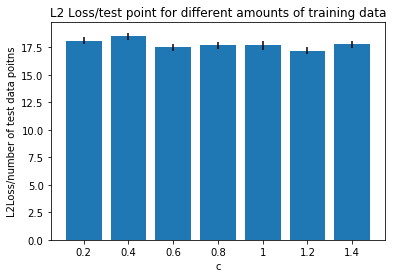

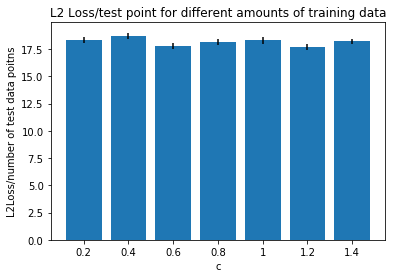

In [14]:
num4It = (len(L2Loss_all_modified_0))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_0[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_0[stttats])/math.sqrt(len(L2Loss_all_modified_0[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_0[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,const_modified_0)
plt.xlabel('c')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()

num4It = (len(L2Loss_all_modified_1))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_1[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_1[stttats])/math.sqrt(len(L2Loss_all_modified_1[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_1[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,const_modified_1)
plt.xlabel('c')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()

num4It = (len(L2Loss_all_modified_01))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_01[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_01[stttats])/math.sqrt(len(L2Loss_all_modified_01[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_01[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,const_modified_01)
plt.xlabel('c')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()